# Get dataset

In [ ]:
# Download the zipped data set (faster than getting from kaggle)
import gdown
file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti
From (redirected): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti&confirm=t&uuid=48f0ef62-9489-493b-a4b0-4da1d4522c2c
To: /content/data.zip
100%|██████████| 110M/110M [00:01<00:00, 74.2MB/s]


'data.zip'

In [ ]:
# Unzip the downloaded into working directory
!unzip -q data.zip -d dataset

# Dependacies

In [ ]:
# Get all dependacy
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load images

In [ ]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "dataset/train/REAL"
train_FAKE = "dataset/train/FAKE"
test_REAL = "dataset/test/REAL"
test_FAKE = "dataset/test/FAKE"

tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


# Get Extra Features

In [ ]:
# Residual

def to_gray(x):
    # tf expects float images; convert first
    x = tf.image.convert_image_dtype(x, tf.float32)
    return tf.image.rgb_to_grayscale(x)  # (H, W, 1)

def gaussian_denoise_gray(x):
    base = tf.constant([
        [1/16, 2/16, 1/16],
        [2/16, 4/16, 2/16],
        [1/16, 2/16, 1/16]
    ], tf.float32)

    kernel = tf.reshape(base, (3, 3, 1, 1))  # (3,3,input_depth=1,mult=1)

    return tf.nn.depthwise_conv2d(
        x, kernel,
        strides=[1,1,1,1],
        padding="SAME"
    )

def extract_noise_batch_gray(X_batch):
    gray = to_gray(X_batch)               # (B,32,32,1)
    den = gaussian_denoise_gray(gray)     # denoised grayscale
    return gray - den                     # noise residual


def extract_noise_dataset_gray(X, batch_size=256):
    residuals_list = []

    for i in range(0, X.shape[0], batch_size):
        batch = X[i : i+batch_size]

        # Compute residuals on GPU
        res = extract_noise_batch_gray(batch)

        # Move to CPU immediately to free GPU memory
        residuals_list.append(res.numpy())

    # Concatenate on CPU (safe)
    return np.concatenate(residuals_list, axis=0)

In [ ]:
# ELA

from PIL import Image
import io

def ela_single_image(img_array, quality=90, scale=30):
    """
    img_array: numpy array (H, W, 3) in [0..255] or [0..1]
    quality: JPEG recompression quality
    scale: how much to amplify the ELA differences
    Returns: ELA image in grayscale (H, W)
    """
    # Ensure uint8 0..255
    if img_array.dtype != np.uint8:
        img = (img_array * 255).astype(np.uint8)
    else:
        img = img_array

    # Convert to PIL Image
    pil_img = Image.fromarray(img)

    # Convert to grayscale
    pil_img = pil_img.convert("L")

    # Save to JPEG in memory
    buffer = io.BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)

    # Reload the JPEG image
    compressed = Image.open(buffer).convert("L")
    compressed = np.array(compressed)

    # Difference
    ela = np.abs(np.array(pil_img, dtype=np.float32) - compressed.astype(np.float32))

    # Amplify
    ela = np.clip(ela * scale, 0, 255).astype(np.uint8)

    return ela


def ela_batch(images, quality=90, scale=30):
    """
    images: numpy array (N, H, W, 3)
    Returns: array of grayscale ELA images (N, H, W)
    """
    ela_results = []
    for i in range(images.shape[0]):
        ela_img = ela_single_image(images[i], quality=quality, scale=scale)
        ela_results.append(ela_img)
    return np.stack(ela_results, axis=0)

In [ ]:
# Get residual
X_train_res = extract_noise_dataset_gray(X_train)
X_test_res = extract_noise_dataset_gray(test_real_images)

# Get ela
X_train_ela = ela_batch(X_train)
X_test_ela = ela_batch(X_test)
print(X_train_ela.shape)

(100000, 32, 32)


# EDA

In [ ]:
def showPixelMean_RGB(img, title):
  R = img[:, :, 0]
  G = img[:, :, 1]
  B = img[:, :, 2]

  zeros = tf.zeros_like(R)

  red_only   = tf.stack([R, zeros, zeros], axis=-1)
  green_only = tf.stack([zeros, G, zeros], axis=-1)
  blue_only  = tf.stack([zeros, zeros, B], axis=-1)

  plt.figure(figsize=(10, 4))
  plt.suptitle(title, fontsize=16)

  plt.subplot(1, 3, 1)
  plt.imshow(R, cmap="gray")
  plt.title("Red Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 2)
  plt.imshow(G, cmap="gray")
  plt.title("Green Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.subplot(1, 3, 3)
  plt.imshow(B, cmap="gray")
  plt.title("Blue Channel (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.show()

In [ ]:
def showPixelMean_Grey(img, title):

  zeros = tf.zeros_like(img)

  plt.figure(figsize=(10, 4))
  plt.suptitle(title, fontsize=16)

  plt.imshow(img, cmap="gray")
  plt.title("Pixelvalues (with values)")
  plt.colorbar()  # <-- shows pixel values

  plt.show()

In [ ]:
train_real = tf.reduce_mean( train_real_images, axis=[0])
train_fake = tf.reduce_mean( train_fake_images, axis=[0])

train_real_std = tf.math.reduce_std(tf.cast(train_real_images, tf.float32) , axis=[0])
train_fake_std = tf.math.reduce_std(tf.cast(train_fake_images, tf.float32) , axis=[0])

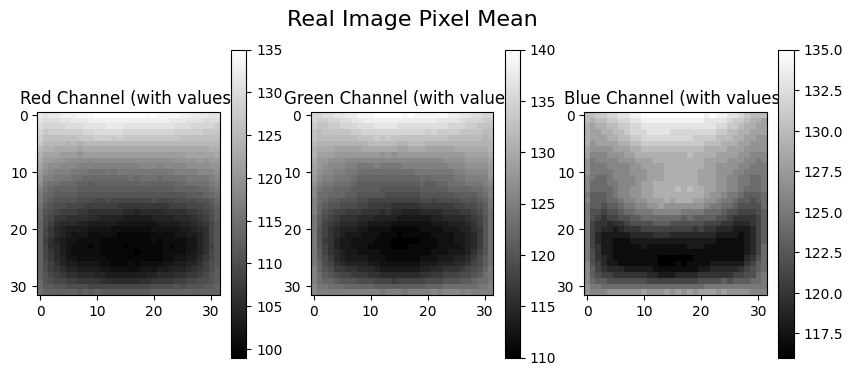

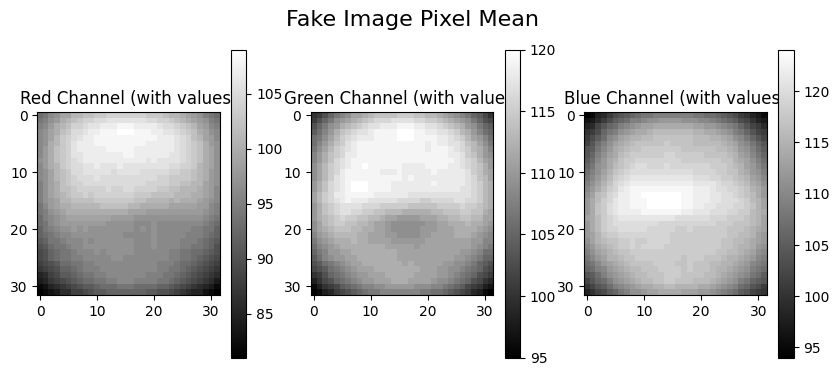

In [ ]:
showPixelMean_RGB(train_real,"Real Image Pixel Mean")
showPixelMean_RGB(train_fake,"Fake Image Pixel Mean")

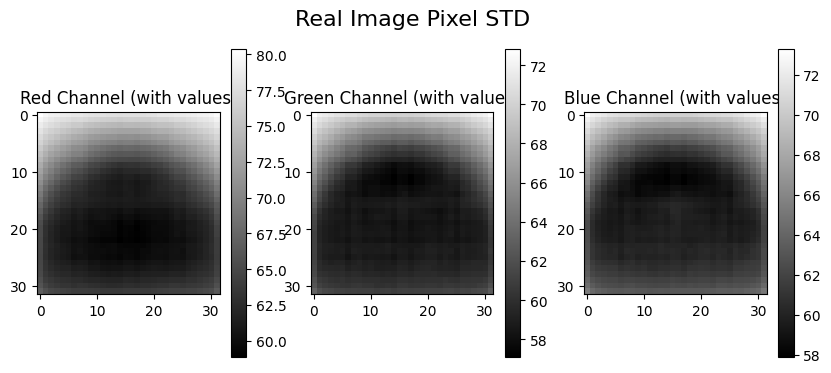

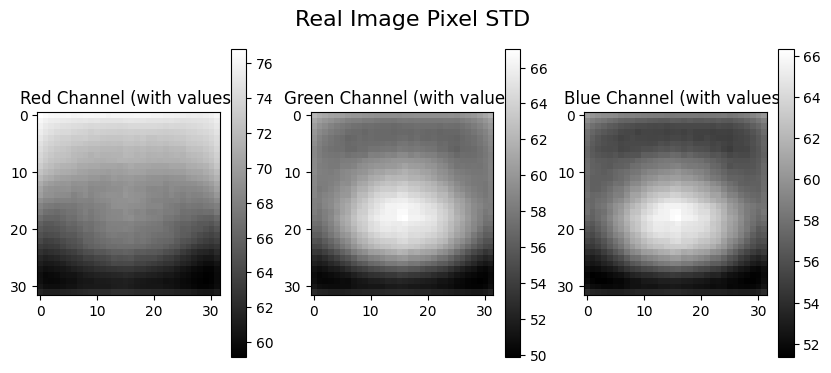

In [ ]:
showPixelMean_RGB(train_real_std,"Real Image Pixel STD")
showPixelMean_RGB(train_fake_std,"Fake Image Pixel STD")

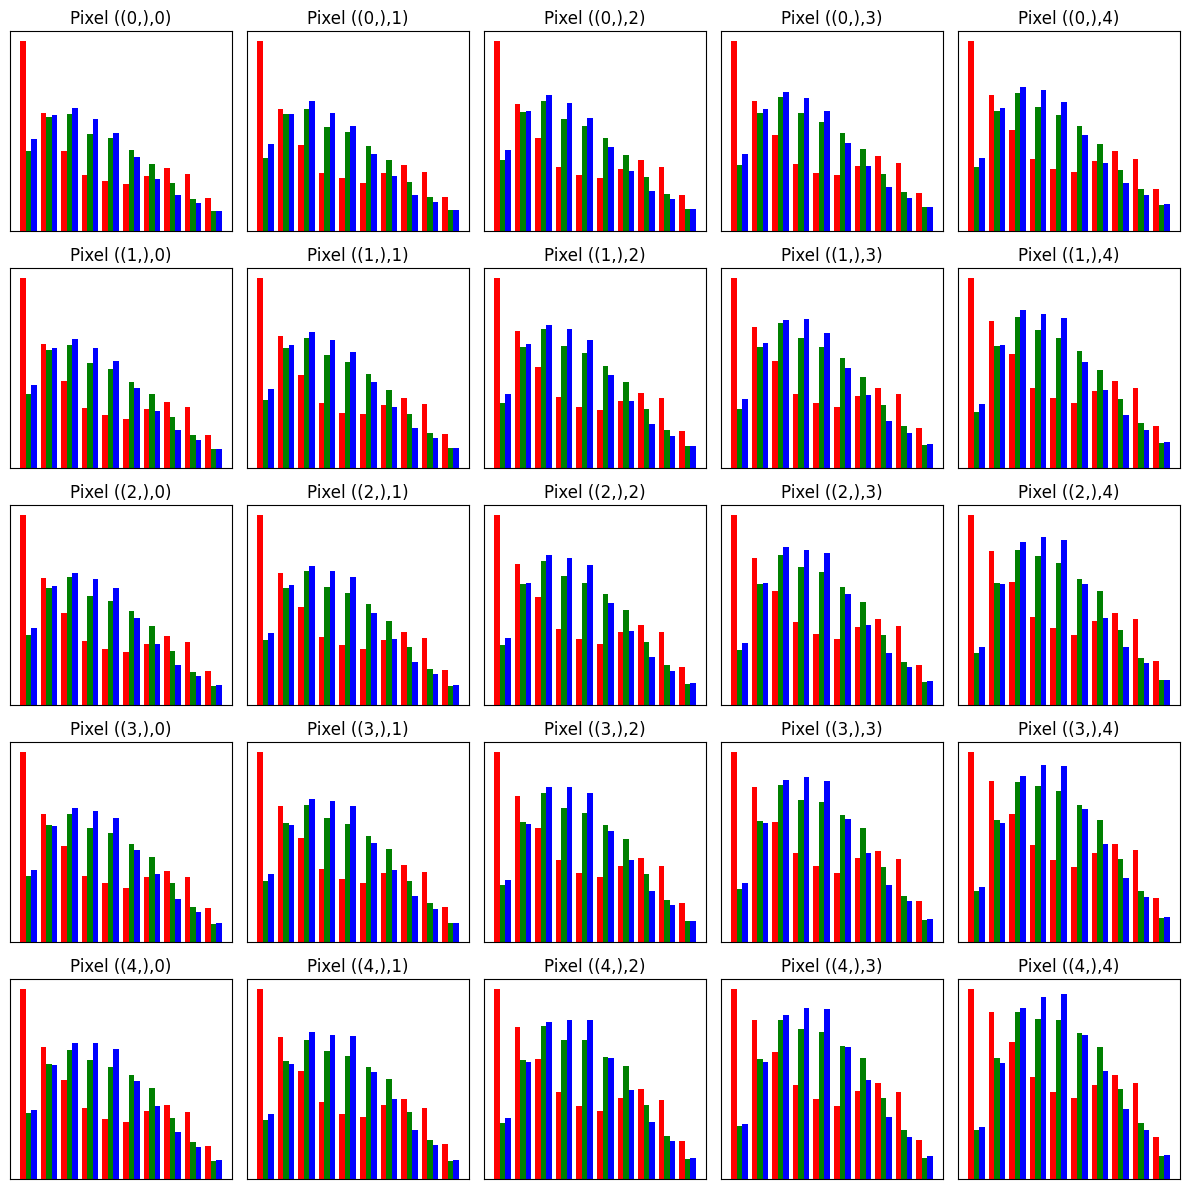

In [ ]:
batch_images = train_fake_images

# Pick a pixel location (i,j), e.g., top-left pixel
num_rows = 5
num_cols = 5
shift_rows= 0
shift_cols = 0

plt.figure(figsize=(12, 12))  # reasonable figure size
for i in range(num_rows):
    for j in range(num_cols):
        pixel_values = batch_images[:, shift_rows+i, shift_cols+j]  # values across batch
        plt.subplot(num_rows, num_cols, i*num_cols + j + 1)
        plt.hist(pixel_values, bins=10, color = ['red','green','blue'])
        plt.title(f"Pixel ({shift_rows+i,},{shift_cols+j})")
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
train_real_res = tf.reduce_mean( extract_noise_dataset_gray(train_real_images), axis=[0])
train_fake_res = tf.reduce_mean( extract_noise_dataset_gray(train_fake_images), axis=[0])

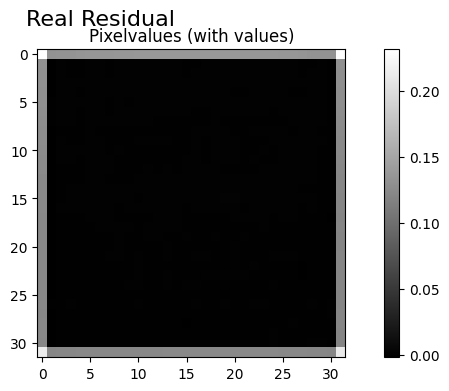

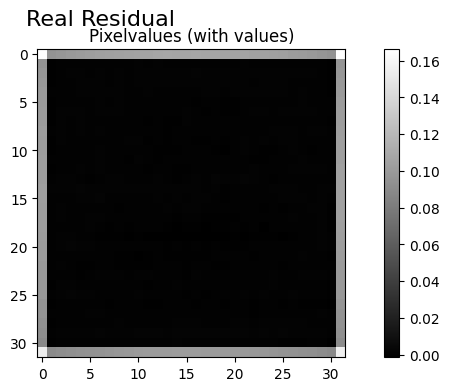

In [ ]:
showPixelMean_Grey(train_real_res,"Real Residual Mean")
showPixelMean_Grey(train_fake_res,"Fake Residual Mean")

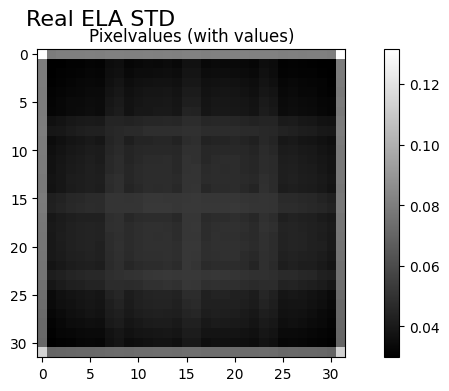

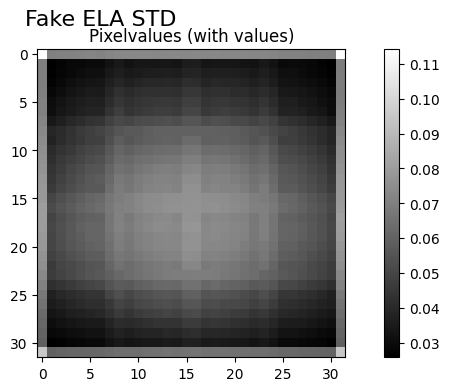

In [ ]:
train_real_ela_std = tf.math.reduce_std(tf.cast(extract_noise_dataset_gray(train_real_images), tf.float32) , axis=[0])
train_fake_ela_std = tf.math.reduce_std(tf.cast(extract_noise_dataset_gray(train_fake_images), tf.float32) , axis=[0])

showPixelMean_Grey(train_real_ela_std,"Real ELA STD")
showPixelMean_Grey(train_fake_ela_std,"Fake ELA STD")

In [ ]:
train_real_ela = tf.reduce_mean( ela_batch(train_real_images), axis=[0])
train_fake_ela = tf.reduce_mean( ela_batch(train_fake_images), axis=[0])

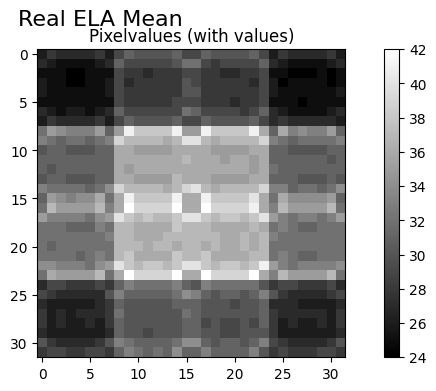

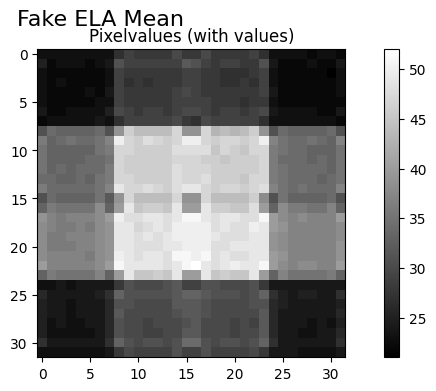

In [ ]:
showPixelMean_Grey(train_real_ela,"Real ELA Mean")
showPixelMean_Grey(train_fake_ela,"Fake ELA Mean")

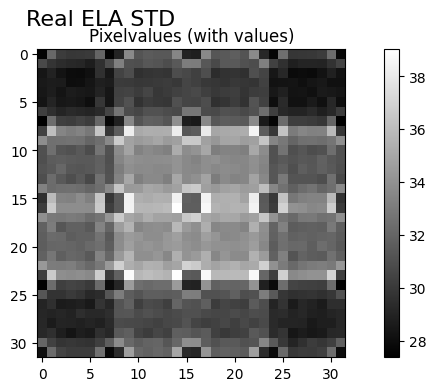

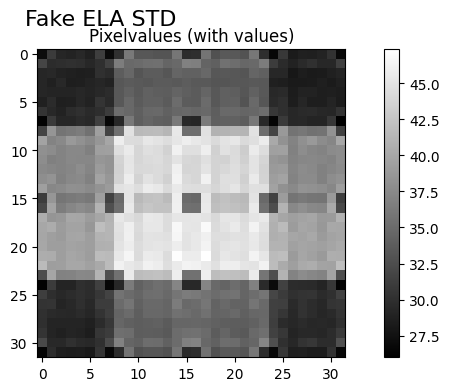

In [ ]:
train_real_ela_std = tf.math.reduce_std(tf.cast(ela_batch(train_real_images), tf.float32) , axis=[0])
train_fake_ela_std = tf.math.reduce_std(tf.cast(ela_batch(train_fake_images), tf.float32) , axis=[0])

showPixelMean_Grey(train_real_ela_std,"Real ELA STD")
showPixelMean_Grey(train_fake_ela_std,"Fake ELA STD")

# Model

In [ ]:
def predictKNN(X_test_exp, X_train):
  X = X_train
  batch_size = 1
  k = 10
  num_test = X_test_exp.shape[0]
  preds_list = []

  for start in range(0, num_test, batch_size):
      end = min(start + batch_size, num_test)
      if start%10 == 0:
        print("Start = ", start, ", end = ", end)
      # Take the current batch
      X_batch = X_test_exp[start:end]           # [batch, H, W, C]

      # Expand dims to compute pairwise distances: [batch, 1, H, W, C] - [1, num_train, H, W, C]
      X_batch_exp = tf.expand_dims(tf.cast(X_batch,tf.float32), axis=1)
      X_train_exp_batch = tf.expand_dims(tf.cast(X,tf.float32), axis=0)

      # Compute L2 distance
      distances = tf.reduce_sum(tf.square(X_batch_exp - X_train_exp_batch), axis=[2,3,4])

      # Get indices of k nearest neighbors
      _, indices = tf.math.top_k(-distances, k=k)  # negative for smallest

      # Gather labels of nearest neighbors
      nearest_labels = tf.gather(y_train, indices)

      # Majority vote
      predictions = tf.cast(tf.reduce_sum(nearest_labels, axis=1) >= (k//2), tf.int32)

      # Convert to numpy and store in list
      preds_list.append(predictions.numpy())

  # Concatenate all batches at the end
  preds = np.concatenate(preds_list)

  return preds

In [ ]:
def predReport(y_test, y_pred):
  # --- Classification Report ---
  print("\n--- Classification Report ---")
  report = classification_report(y_test, y_pred, target_names=['FAKE (0)', 'REAL (1)'], digits=4)
  print(report)

  # --- Confusion Matrix ---
  print("\n--- Confusion Matrix ---")
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(7, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')
  plt.show()

Start =  0 , end =  1
Start =  10 , end =  11
Start =  20 , end =  21
Start =  30 , end =  31
Start =  40 , end =  41
Start =  50 , end =  51
Start =  60 , end =  61
Start =  70 , end =  71
Start =  80 , end =  81
Start =  90 , end =  91

--- Original Image Report ---

--- Classification Report ---
              precision    recall  f1-score   support

    FAKE (0)     0.5938    0.3878    0.4691        49
    REAL (1)     0.5588    0.7451    0.6387        51

    accuracy                         0.5700       100
   macro avg     0.5763    0.5664    0.5539       100
weighted avg     0.5759    0.5700    0.5556       100


--- Confusion Matrix ---


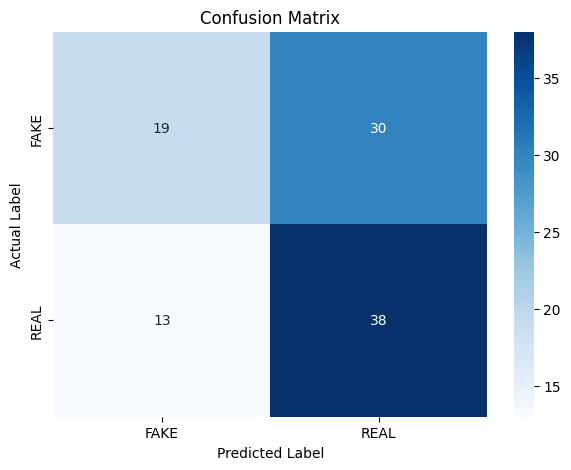

In [ ]:
# Regular image
X_test_exp = X_test[:100]
preds = predictKNN(X_test_exp,X_train)

print("\n--- Original Image Report ---")

y_test_exp = y_test[:100]

predReport(y_test_exp, preds)

Start =  0 , end =  1
Start =  10 , end =  11
Start =  20 , end =  21
Start =  30 , end =  31
Start =  40 , end =  41
Start =  50 , end =  51
Start =  60 , end =  61
Start =  70 , end =  71
Start =  80 , end =  81
Start =  90 , end =  91

--- Residual Image Report ---

--- Classification Report ---
              precision    recall  f1-score   support

    FAKE (0)     0.8462    0.2245    0.3548        49
    REAL (1)     0.5632    0.9608    0.7101        51

    accuracy                         0.6000       100
   macro avg     0.7047    0.5926    0.5325       100
weighted avg     0.7019    0.6000    0.5360       100


--- Confusion Matrix ---


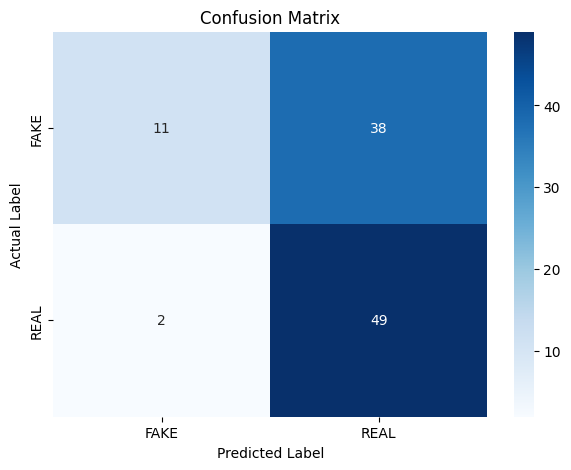

In [ ]:
# Residual image
X_test_exp = X_test_res[:100]
preds = predictKNN(X_test_exp,X_train_res)

print("\n--- Residual Image Report ---")

y_test_exp = y_test[:100]

predReport(y_test_exp, preds)

Start =  0 , end =  1
Start =  10 , end =  11
Start =  20 , end =  21
Start =  30 , end =  31
Start =  40 , end =  41
Start =  50 , end =  51
Start =  60 , end =  61
Start =  70 , end =  71
Start =  80 , end =  81
Start =  90 , end =  91

--- ELA Image Report ---

--- Classification Report ---
              precision    recall  f1-score   support

    FAKE (0)     0.3571    0.1020    0.1587        49
    REAL (1)     0.4884    0.8235    0.6131        51

    accuracy                         0.4700       100
   macro avg     0.4228    0.4628    0.3859       100
weighted avg     0.4241    0.4700    0.3905       100


--- Confusion Matrix ---


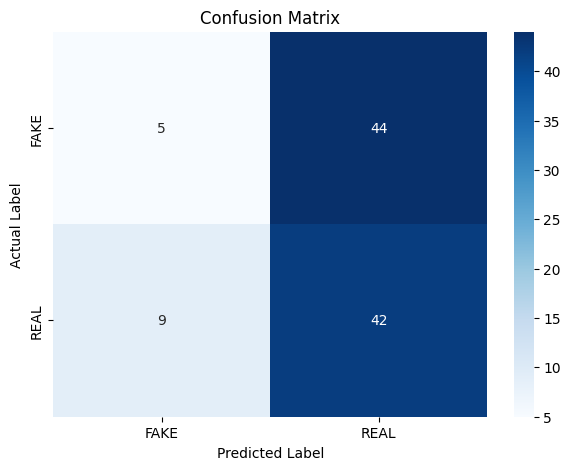

In [ ]:
# ELA image
X_test_exp = np.expand_dims(X_test_ela[:100], axis=-1)
X_train_exp = np.expand_dims(X_train_ela, axis=-1)
preds = predictKNN(X_test_exp,X_train_exp)

print("\n--- ELA Image Report ---")

y_test_exp = y_test[:100]

predReport(y_test_exp, preds)

# PCA

In [ ]:
num_images = X_train.shape[0]
X_flat = X_train.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # 2D visualization
X_pca = pca.fit_transform(X_scaled)

# Fraction of variance explained by each component
print(pca.explained_variance_ratio_)

# Cumulative variance explained
print(np.cumsum(pca.explained_variance_ratio_))

[0.23048318 0.10472659]
[0.23048318 0.33520978]


In [ ]:
sum = tf.reduce_sum(X_train_ela, axis=[1,2])
sum.shape

TensorShape([100000])

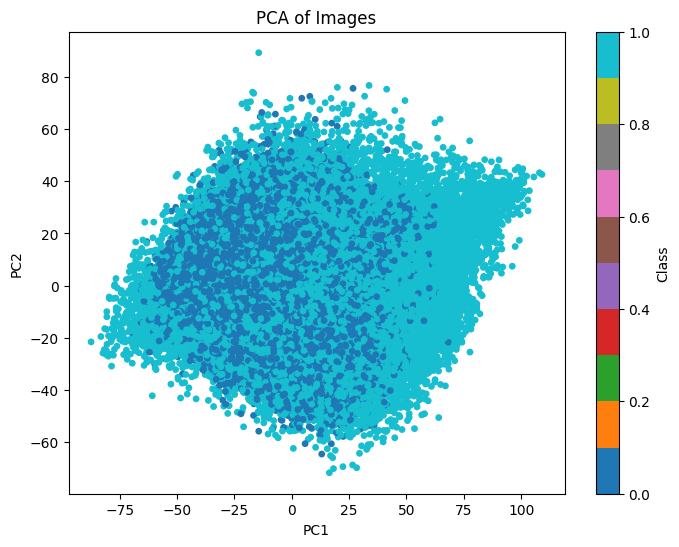

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', s=15)  # x=PC1, y=PC2
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Images')
plt.colorbar(label='Class')
plt.show()

# Extra models test

In [ ]:
# Expand dims to compute pairwise distances: [batch, 1, H, W, C] - [1, num_train, H, W, C]
X_test_exp = tf.expand_dims(tf.cast(X_test,tf.float32), axis=0)

# Compute L2 distance
distances_real= tf.reduce_sum(tf.square(X_test_exp - tf.cast(train_real,tf.float32)), axis=[2,3,4])
distances_fake= tf.reduce_sum(tf.square(X_test_exp - tf.cast(train_fake,tf.float32)), axis=[2,3,4])
result = tf.cast(distances_fake > distances_real, tf.int32)

In [ ]:
# Expand dims to compute pairwise distances: [batch, 1, H, W, C] - [1, num_train, H, W, C]
X_test_exp = tf.expand_dims(tf.cast(X_test,tf.float32), axis=0)

# Compute L2 distance
Z_real= tf.reduce_mean(tf.abs(X_test_exp - tf.cast(train_real,tf.float32))/train_real_std, axis=[2,3,4])
Z_fake= tf.reduce_mean(tf.abs(X_test_exp - tf.cast(train_fake,tf.float32))/train_fake_std, axis=[2,3,4])
result = tf.cast(Z_fake > Z_real, tf.int32)


--- Classification Report ---
              precision    recall  f1-score   support

    FAKE (0)     0.6015    0.5566    0.5782     10000
    REAL (1)     0.5874    0.6312    0.6085     10000

    accuracy                         0.5939     20000
   macro avg     0.5944    0.5939    0.5933     20000
weighted avg     0.5944    0.5939    0.5933     20000


--- Confusion Matrix ---


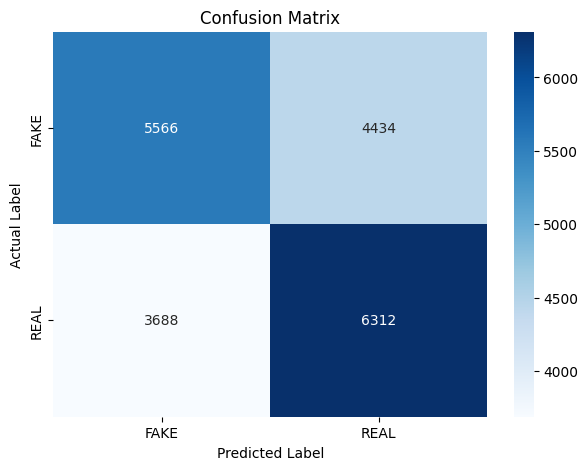

In [ ]:
y_test = y_test
y_pred = tf.squeeze(result, axis=0)

# --- Classification Report ---
print("\n--- Classification Report ---")
report = classification_report(y_test, y_pred, target_names=['FAKE (0)', 'REAL (1)'], digits=4)
print(report)

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
img_path = "0184 (8).jpg"
img = Image.open(img_path)
Real_1 = np.array(img)

img_path = "0197 (2).jpg"
img = Image.open(img_path)
Real_2 = np.array(img)

img_path = "71 (5).jpg"
img = Image.open(img_path)
Fake = np.array(img)
Fake.shape

(32, 32, 3)

In [ ]:
distances_real_real= tf.reduce_sum(tf.square(Real_1 - tf.cast(Real_2,tf.float32)), axis=[0,1,2])
distances_real_fake= tf.reduce_sum(tf.square(Real_1 - tf.cast(Fake,tf.float32)), axis=[0,1,2])

In [ ]:
distances_real_real

<tf.Tensor: shape=(), dtype=float32, numpy=26523300.0>

In [ ]:
distances_real_fake

<tf.Tensor: shape=(), dtype=float32, numpy=22868936.0>